In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import random

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient

In [ ]:
#forgot to set random seed in original transfer learning model
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

##Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/Colab Notebooks/summer_challenge/Final"

!unzip -q "/content/drive/My Drive/Colab Notebooks/summer_challenge/Training.zip" -d "/content/drive/My Drive/Colab Notebooks/summer_challenge"
!unzip -q "/content/drive/My Drive/Colab Notebooks/summer_challenge/Final.zip" -d "/content/drive/My Drive/Colab Notebooks/summer_challenge/Final"

replace /content/drive/My Drive/Colab Notebooks/summer_challenge/Training/RGBImages/RGB_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace /content/drive/My Drive/Colab Notebooks/summer_challenge/Final/DepthImages/Depth_7.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
full_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/summer_challenge/Training/Train.csv", dtype={'image_id': str})

#Remove image 332 from dataframe because it's missing from the files
full_df = full_df[full_df['image_id'] != '332'].reset_index(drop=True)

##Data Pipeline

In [ ]:
#Image Loading Function

IMG_SIZE = (224,224) #pretrained models expect 224×224 input size

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)   # imagenet scales to [-1,1] -> useful for pretrained models

    return img

In [ ]:
#Convert variety column to integers before building datasets
full_df["Variety"], variety_lookup = pd.factorize(full_df["Variety"]) #original variety names are stored in lookup
full_df["Variety"] = full_df["Variety"].astype("int32")

In [ ]:
#DryWeightShoot is skewed to left - stratified shuffle split for train/val

#Create quartile bins for stratification
full_df["dws_bin"] = pd.qcut(full_df["DryWeightShoot"], q=4, labels=False, duplicates="drop")

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(full_df, full_df["dws_bin"]):
    train_df = full_df.iloc[train_idx].reset_index(drop=True)
    val_df   = full_df.iloc[val_idx].reset_index(drop=True)

#drop the quartile bins after stratified shuffle split
train_df = train_df.drop(columns=["dws_bin"])
val_df   = val_df.drop(columns=["dws_bin"])

In [4]:
#image augmentation function
def augment_image(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random rotation (±15 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))

    # Random brightness (±20%)
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Clip values to valid range
    image = tf.clip_by_value(image, -1.0, 1.0)

    return image, label

In [ ]:
#Build TF dataset from dataframe

img_dir = "/content/drive/My Drive/Colab Notebooks/summer_challenge/Training/RGBImages"

def process_row(image_path, label):
    img = load_image(image_path)
    return img, label

def make_dataset(df, batch_size=16, shuffle=False, augment=False):
    # Build image paths
    image_paths = [f"{img_dir}/RGB_{img_id}.png" for img_id in df["image_id"]]
    labels = df["DryWeightShoot"].values

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)

    ds = ds.map(process_row, num_parallel_calls=tf.data.AUTOTUNE)

    # Add augmentation if training
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_ds = make_dataset(train_df, batch_size=16, shuffle=True, augment=True)
val_ds = make_dataset(val_df, batch_size=16, shuffle=False, augment=False)

#Model 0

##Basic CNN

In [ ]:
def build_model():
    # Load pretrained ResNet50 (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    # Build regression head
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile with MAE loss
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae']
    )

    return model

# Create model
model = build_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

##Train and Evaluate Performance

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_mae',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        'best_model.h5',
        monitor='val_mae',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# Check final validation MAE
best_mae = min(history.history['val_mae'])
print(f"Best Validation MAE: {best_mae:.4f}")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.4293 - mae: 4.4293
Epoch 1: val_mae improved from inf to 3.69208, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 4.4042 - mae: 4.4042 - val_loss: 3.6921 - val_mae: 3.6921
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 3.5310 - mae: 3.5310
Epoch 2: val_mae improved from 3.69208 to 3.62998, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 948ms/step - loss: 3.5504 - mae: 3.5504 - val_loss: 3.6300 - val_mae: 3.6300
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 3.6940 - mae: 3.6940
Epoch 3: val_mae improved from 3.62998 to 3.52286, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 750ms/step - loss: 3.6934 - mae: 3.6934 - val_loss: 3.5229 - val_mae: 3.5229
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 3.6367 - mae: 3.6367
Epoch 4: val_mae improved from 3.52286 to 3.48620, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - loss: 3.6366 - mae: 3.6366 - val_loss: 3.4862 - val_mae: 3.4862
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - loss: 3.6586 - mae: 3.6586
Epoch 5: val_mae improved from 3.48620 to 3.43969, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 913ms/step - loss: 3.6622 - mae: 3.6622 - val_loss: 3.4397 - val_mae: 3.4397
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 3.3841 - mae: 3.3841
Epoch 6: val_mae improved from 3.43969 to 3.37748, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 718ms/step - loss: 3.3907 - mae: 3.3907 - val_loss: 3.3775 - val_mae: 3.3775
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 3.5819 - mae: 3.5819
Epoch 7: val_mae improved from 3.37748 to 3.32809, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 781ms/step - loss: 3.5740 - mae: 3.5740 - val_loss: 3.3281 - val_mae: 3.3281
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 3.2641 - mae: 3.2641
Epoch 8: val_mae improved from 3.32809 to 3.28954, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 784ms/step - loss: 3.2786 - mae: 3.2786 - val_loss: 3.2895 - val_mae: 3.2895
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 3.2982 - mae: 3.2982
Epoch 9: val_mae improved from 3.28954 to 3.21797, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 774ms/step - loss: 3.3002 - mae: 3.3002 - val_loss: 3.2180 - val_mae: 3.2180
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 3.4309 - mae: 3.4309
Epoch 10: val_mae improved from 3.21797 to 3.18285, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 638ms/step - loss: 3.4207 - mae: 3.4207 - val_loss: 3.1828 - val_mae: 3.1828
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - loss: 3.3882 - mae: 3.3882
Epoch 11: val_mae improved from 3.18285 to 3.11098, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 802ms/step - loss: 3.3804 - mae: 3.3804 - val_loss: 3.1110 - val_mae: 3.1110
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 2.9869 - mae: 2.9869
Epoch 12: val_mae improved from 3.11098 to 3.04543, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 740ms/step - loss: 3.0013 - mae: 3.0013 - val_loss: 3.0454 - val_mae: 3.0454
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 3.2299 - mae: 3.2299
Epoch 13: val_mae improved from 3.04543 to 2.98016, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 632ms/step - loss: 3.2290 - mae: 3.2290 - val_loss: 2.9802 - val_mae: 2.9802
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 3.3896 - mae: 3.3896
Epoch 14: val_mae improved from 2.98016 to 2.91523, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - loss: 3.3682 - mae: 3.3682 - val_loss: 2.9152 - val_mae: 2.9152
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 3.1072 - mae: 3.1072
Epoch 15: val_mae improved from 2.91523 to 2.85388, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step - loss: 3.1024 - mae: 3.1024 - val_loss: 2.8539 - val_mae: 2.8539
Epoch 16/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 3.0045 - mae: 3.0045
Epoch 16: val_mae improved from 2.85388 to 2.71645, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 687ms/step - loss: 3.0042 - mae: 3.0042 - val_loss: 2.7165 - val_mae: 2.7165
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 3.1425 - mae: 3.1425
Epoch 17: val_mae did not improve from 2.71645
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 738ms/step - loss: 3.1366 - mae: 3.1366 - val_loss: 2.7444 - val_mae: 2.7444
Epoch 18/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 3.1107 - mae: 3.1107
Epoch 18: val_mae improved from 2.71645 to 2.56607, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 744ms/step - loss: 3.0954 - mae: 3.0954 - val_loss: 2.5661 - val_mae: 2.5661
Epoch 19/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 3.0290 - mae: 3.0290
Epoch 19: val_mae did not improve from 2.56607
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 581ms/step - loss: 3.0193 - mae: 3.0193 - val_loss: 2.6960 - val_mae: 2.6960
Epoch 20/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 2.4831 - mae: 2.4831
Epoch 20: val_mae improved from 2.56607 to 2.52982, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 887ms/step - loss: 2.5049 - mae: 2.5049 - val_loss: 2.5298 - val_mae: 2.5298
Epoch 21/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.6807 - mae: 2.6807
Epoch 21: val_mae improved from 2.52982 to 2.51619, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 751ms/step - loss: 2.6858 - mae: 2.6858 - val_loss: 2.5162 - val_mae: 2.5162
Epoch 22/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 2.3654 - mae: 2.3654
Epoch 22: val_mae improved from 2.51619 to 2.34624, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 650ms/step - loss: 2.3801 - mae: 2.3801 - val_loss: 2.3462 - val_mae: 2.3462
Epoch 23/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - loss: 2.4715 - mae: 2.4715
Epoch 23: val_mae improved from 2.34624 to 2.32326, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - loss: 2.4689 - mae: 2.4689 - val_loss: 2.3233 - val_mae: 2.3233
Epoch 24/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.3335 - mae: 2.3335
Epoch 24: val_mae improved from 2.32326 to 2.10615, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 656ms/step - loss: 2.3421 - mae: 2.3421 - val_loss: 2.1061 - val_mae: 2.1061
Epoch 25/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 2.4520 - mae: 2.4520
Epoch 25: val_mae did not improve from 2.10615
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 682ms/step - loss: 2.4511 - mae: 2.4511 - val_loss: 2.1836 - val_mae: 2.1836
Epoch 26/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 2.6415 - mae: 2.6415
Epoch 26: val_mae improved from 2.10615 to 2.09258, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 773ms/step - loss: 2.6127 - mae: 2.6127 - val_loss: 2.0926 - val_mae: 2.0926
Epoch 27/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.4960 - mae: 2.4960
Epoch 27: val_mae improved from 2.09258 to 2.04847, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 641ms/step - loss: 2.4744 - mae: 2.4744 - val_loss: 2.0485 - val_mae: 2.0485
Epoch 28/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 2.1765 - mae: 2.1765
Epoch 28: val_mae improved from 2.04847 to 1.99875, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 781ms/step - loss: 2.1765 - mae: 2.1765 - val_loss: 1.9988 - val_mae: 1.9988
Epoch 29/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 2.0599 - mae: 2.0599
Epoch 29: val_mae improved from 1.99875 to 1.92801, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 764ms/step - loss: 2.0694 - mae: 2.0694 - val_loss: 1.9280 - val_mae: 1.9280
Epoch 30/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 2.2130 - mae: 2.2130
Epoch 30: val_mae improved from 1.92801 to 1.87031, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - loss: 2.2090 - mae: 2.2090 - val_loss: 1.8703 - val_mae: 1.8703
Epoch 31/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - loss: 2.1860 - mae: 2.1860
Epoch 31: val_mae did not improve from 1.87031
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 757ms/step - loss: 2.1693 - mae: 2.1693 - val_loss: 1.9410 - val_mae: 1.9410
Epoch 32/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.2564 - mae: 2.2564
Epoch 32: val_mae improved from 1.87031 to 1.76325, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 639ms/step - loss: 2.2520 - mae: 2.2520 - val_loss: 1.7632 - val_mae: 1.7632
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.9037 - mae: 1.9037
Epoch 33: val_mae improved from 1.76325 to 1.74867, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 741ms/step - loss: 1.9075 - mae: 1.9075 - val_loss: 1.7487 - val_mae: 1.7487
Epoch 34/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 1.9253 - mae: 1.9253
Epoch 34: val_mae did not improve from 1.74867
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 738ms/step - loss: 1.9225 - mae: 1.9225 - val_loss: 1.8828 - val_mae: 1.8828
Epoch 35/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 1.9186 - mae: 1.9186
Epoch 35: val_mae did not improve from 1.74867
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 751ms/step - loss: 1.9152 - mae: 1.9152 - val_loss: 1.9862 - val_mae: 1.9862
Epoch 36/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 2.1534 - mae: 2.1534
Epoch 36: val_mae did not improve from 1.74867
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 683ms/step - loss: 2.1401 - mae: 2.1401 - val_loss: 1.9099 - val_mae: 1.9099
Epoch 37/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 2.1481 - mae: 2.1481
Epoch 37: val_mae improved from 1.74867 to 1.64998, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 727ms/step - loss: 2.1380 - mae: 2.1380 - val_loss: 1.6500 - val_mae: 1.6500
Epoch 38/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 1.8231 - mae: 1.8231
Epoch 38: val_mae improved from 1.64998 to 1.61365, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 896ms/step - loss: 1.8278 - mae: 1.8278 - val_loss: 1.6136 - val_mae: 1.6136
Epoch 39/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 1.9584 - mae: 1.9584
Epoch 39: val_mae did not improve from 1.61365
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 622ms/step - loss: 1.9564 - mae: 1.9564 - val_loss: 1.6392 - val_mae: 1.6392
Epoch 40/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.0763 - mae: 2.0763
Epoch 40: val_mae did not improve from 1.61365
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - loss: 2.0714 - mae: 2.0714 - val_loss: 1.8413 - val_mae: 1.8413
Epoch 41/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 1.9580 - mae: 1.9580
Epoch 41: val_mae did not improve from 1.61365
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 843ms/step - loss: 1.9553 - mae: 1.9553 - val_loss: 1.9939 - val_mae: 1.9939
Epoch 42/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 2.0076 - mae: 2.0076
Epoch 42: val_mae improved from 1.61365 to 1.58716, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 770ms/step - loss: 2.0093 - mae: 2.0093 - val_loss: 1.5872 - val_mae: 1.5872
Epoch 43/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 1.7552 - mae: 1.7552
Epoch 43: val_mae improved from 1.58716 to 1.58654, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 671ms/step - loss: 1.7559 - mae: 1.7559 - val_loss: 1.5865 - val_mae: 1.5865
Epoch 44/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 1.8182 - mae: 1.8182
Epoch 44: val_mae did not improve from 1.58654
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 859ms/step - loss: 1.8221 - mae: 1.8221 - val_loss: 1.6370 - val_mae: 1.6370
Epoch 45/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.9341 - mae: 1.9341
Epoch 45: val_mae improved from 1.58654 to 1.53641, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 718ms/step - loss: 1.9276 - mae: 1.9276 - val_loss: 1.5364 - val_mae: 1.5364
Epoch 46/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 1.6497 - mae: 1.6497
Epoch 46: val_mae did not improve from 1.53641
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 601ms/step - loss: 1.6624 - mae: 1.6624 - val_loss: 1.6085 - val_mae: 1.6085
Epoch 47/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 1.6648 - mae: 1.6648
Epoch 47: val_mae improved from 1.53641 to 1.51406, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 862ms/step - loss: 1.6688 - mae: 1.6688 - val_loss: 1.5141 - val_mae: 1.5141
Epoch 48/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.8293 - mae: 1.8293
Epoch 48: val_mae did not improve from 1.51406
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 693ms/step - loss: 1.8261 - mae: 1.8261 - val_loss: 1.8199 - val_mae: 1.8199
Epoch 49/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1.8057 - mae: 1.8057
Epoch 49: val_mae did not improve from 1.51406
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 656ms/step - loss: 1.8154 - mae: 1.8154 - val_loss: 1.5550 - val_mae: 1.5550
Epoch 50/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - loss: 1.8198 - mae: 1.8198
Epoch 50: val_mae improved from 1.51406 to 1.50074, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 806ms/step - loss: 1.8159 - mae: 1.8159 - val_loss: 1.5007 - val_mae: 1.5007
Epoch 51/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 1.4694 - mae: 1.4694
Epoch 51: val_mae did not improve from 1.50074
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 585ms/step - loss: 1.4914 - mae: 1.4914 - val_loss: 1.5028 - val_mae: 1.5028
Epoch 52/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 1.9711 - mae: 1.9711
Epoch 52: val_mae did not improve from 1.50074
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 833ms/step - loss: 1.9638 - mae: 1.9638 - val_loss: 1.6705 - val_mae: 1.6705
Epoch 53/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 1.6387 - mae: 1.6387
Epoch 53: val_mae did not improve from 1.50074
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 735ms/step - loss: 1.6496 - mae: 1.6496 - val_loss: 1.5702 - val_mae: 1.5702
Epoch 54/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 1.7917 - mae: 1.7917
Epoch 54: val_mae did not improve from 1.50074
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 590ms/step - loss: 1

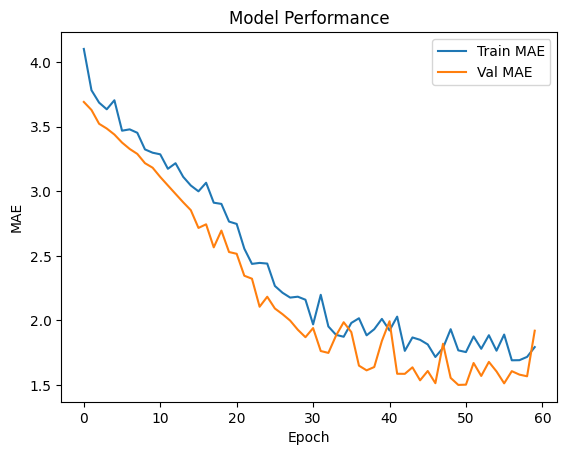

In [ ]:
# Plot training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Model Performance')
plt.show()

# Model 1

In [5]:
#Image Loading Function

IMG_SIZE = (224,224) #pretrained models expect 224×224 input size

def load_image_efficient(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_efficient(img)   # imagenet scales to [-1,1] -> useful for pretrained models

    return img

In [6]:
#Convert variety column to integers before building datasets
full_df["Variety"], variety_lookup = pd.factorize(full_df["Variety"]) #original variety names are stored in lookup
full_df["Variety"] = full_df["Variety"].astype("int32")

In [7]:
#DryWeightShoot is skewed to left - stratified shuffle split for train/val

#Create quartile bins for stratification
full_df["dws_bin"] = pd.qcut(full_df["DryWeightShoot"], q=4, labels=False, duplicates="drop")

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(full_df, full_df["dws_bin"]):
    train_df = full_df.iloc[train_idx].reset_index(drop=True)
    val_df   = full_df.iloc[val_idx].reset_index(drop=True)

#drop the quartile bins after stratified shuffle split
train_df = train_df.drop(columns=["dws_bin"])
val_df   = val_df.drop(columns=["dws_bin"])

In [8]:
#augmentation function doesn't need to be repeated

In [9]:
#Build TF dataset from dataframe

img_dir = "/content/drive/My Drive/Colab Notebooks/summer_challenge/Training/RGBImages"

def process_row(image_path, label):
    img = load_image_efficient(image_path)
    return img, label

def make_dataset(df, batch_size=16, shuffle=False, augment=False):
    # Build image paths
    image_paths = [f"{img_dir}/RGB_{img_id}.png" for img_id in df["image_id"]]
    labels = df["DryWeightShoot"].values

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)

    ds = ds.map(process_row, num_parallel_calls=tf.data.AUTOTUNE)

    # Add augmentation if training
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_ds = make_dataset(train_df, batch_size=16, shuffle=True, augment=True)
val_ds = make_dataset(val_df, batch_size=16, shuffle=False, augment=False)

##EfficientNet

In [12]:
def build_model():
    # Load pretrained ResNet50 (without top classification layer)
    model_efficient = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    model_efficient.trainable = False

    # Build regression head
    inputs = layers.Input(shape=(224, 224, 3))
    x = model_efficient(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model_efficient = models.Model(inputs=inputs, outputs=outputs)

    # Compile with MAE loss
    model_efficient.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae']
    )

    return model_efficient

# Create model
model_efficient = build_model()
model_efficient.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

##Train and Evaluate Performance

In [13]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_mae',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        'best_model.h5',
        monitor='val_mae',
        save_best_only=True,
        verbose=1
    )
]

In [17]:
# Train model
history_efficient = model_efficient.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# Check final validation MAE
best_mae_efficient = min(history_efficient.history['val_mae'])
print(f"Best Validation MAE: {best_mae_efficient:.4f}")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 3.5353 - mae: 3.5353
Epoch 1: val_mae improved from 8.21258 to 8.10399, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 825ms/step - loss: 3.5595 - mae: 3.5595 - val_loss: 8.1040 - val_mae: 8.1040
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 4.0859 - mae: 4.0859
Epoch 2: val_mae improved from 8.10399 to 8.02588, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 774ms/step - loss: 4.0663 - mae: 4.0663 - val_loss: 8.0259 - val_mae: 8.0259
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 3.7641 - mae: 3.7641
Epoch 3: val_mae improved from 8.02588 to 7.68706, saving model to best_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 739ms/step - loss: 3.7704 - mae: 3.7704 - val_loss: 7.6871 - val_mae: 7.6871
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 3.9745 - mae: 3.9745
Epoch 4: val_mae did not improve from 7.68706
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 585ms/step - loss: 3.9725 - mae: 3.9725 - val_loss: 7.8015 - val_mae: 7.8015
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - loss: 3.9678 - mae: 3.9678
Epoch 5: val_mae did not improve from 7.68706
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 820ms/step - loss: 3.9557 - mae: 3.9557 - val_loss: 7.9465 - val_mae: 7.9465
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 3.7599 - mae: 3.7599
Epoch 6: val_mae did not improve from 7.68706
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - loss: 3.7718 - mae: 3.7718 - val_loss: 7.9748 - val_mae: 7.9748
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 3.8958 - mae: 3.8958
Epoch 7: val_mae did not improve from 7.68706
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 769ms/step - loss: 3.8883 - m

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - loss: 3.7634 - mae: 3.7634 - val_loss: 7.1493 - val_mae: 7.1493
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - loss: 3.8975 - mae: 3.8975
Epoch 14: val_mae did not improve from 7.14927
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - loss: 3.8922 - mae: 3.8922 - val_loss: 7.4039 - val_mae: 7.4039
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - loss: 4.1136 - mae: 4.1136
Epoch 15: val_mae did not improve from 7.14927
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 988ms/step - loss: 4.0926 - mae: 4.0926 - val_loss: 7.5230 - val_mae: 7.5230
Epoch 16/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - loss: 3.8284 - mae: 3.8284
Epoch 16: val_mae did not improve from 7.14927
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 826ms/step - loss: 3.8237 - mae: 3.8237 - val_loss: 7.5606 - val_mae: 7.5606
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - loss: 4.0277 - mae: 4.0277
Epoch 17: val_mae did not improve from 7.14927
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 966ms/step - loss:

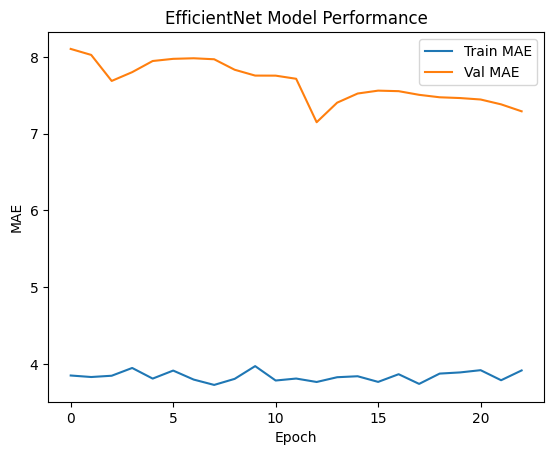

In [18]:
# Plot training and validation MAE
plt.plot(history_efficient.history['mae'], label='Train MAE')
plt.plot(history_efficient.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('EfficientNet Model Performance')
plt.show()